In [1]:
import numpy as np  # numerical library
import xarray as xr  # netCDF library
import pandas as pd

import matplotlib.pyplot as plt  # plotting library
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list

import cftime

In [2]:
# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size

In [3]:
#To compute de climatoloy
yearC1='2004'
yearC2='2009'

## Read the data

In [4]:
DC=xr.open_dataset('./Data/RG_Global_2004-01_2024-03.nc')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/pvb/Dropbox/Oceanografia/Analisis/ComparisonClimatologies/Data/RG_Global_2004-01_2024-03.nc'

In [114]:
DC_temp=DC.temperature.sel(lat=slice( -60, 60))
DC_salt=DC.salinity.sel(lat=slice( -60, 60))

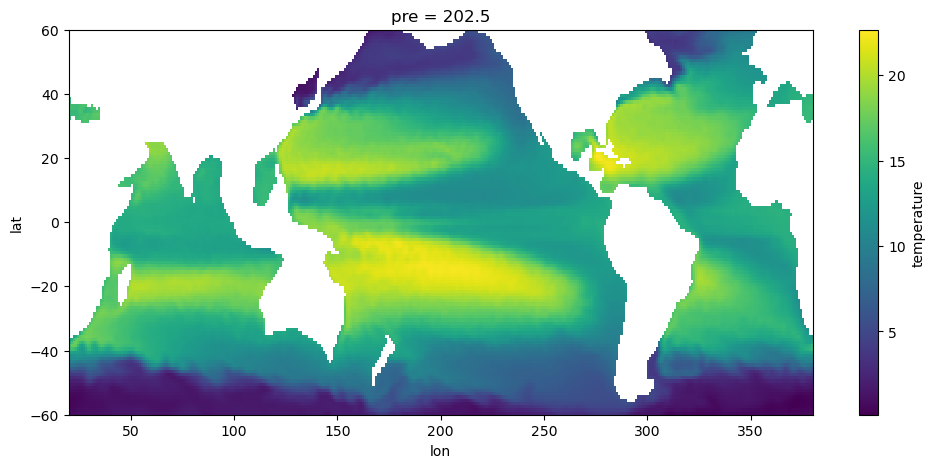

In [154]:
DC_temp.mean('time').sel(pre=200, method='nearest').plot()

## Seasonal cycle
Create seasonal climatology from 1982 to 1992 and the asociated anomaly

In [115]:
#Create monthly climatology
DC_temp_clim = DC_temp.sel(time=slice(yearC1,yearC2)).groupby('time.month').mean(dim='time').load();
DC_salt_clim = DC_salt.sel(time=slice(yearC1,yearC2)).groupby('time.month').mean(dim='time').load();

#Create anomaly
DC_temp_anom = DC_temp.groupby('time.month') - DC_temp_clim
DC_temp_anom.load();

DC_salt_anom = DC_salt.groupby('time.month') - DC_salt_clim
DC_salt_anom.load();

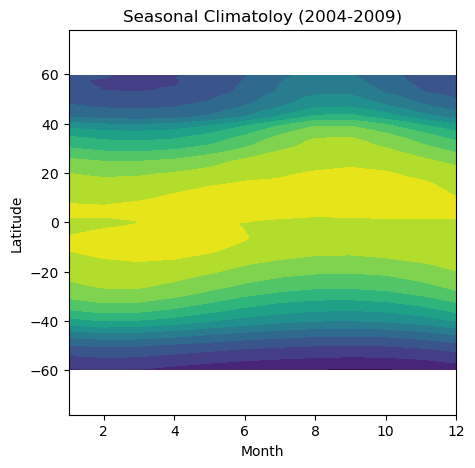

In [116]:
fig, ax = plt.subplots(1, 1 , figsize=(5,5))
ax.contourf(DC_temp_clim.mean(dim='lon').sel(pre=10, method='nearest').month,
                 DC_temp_clim.mean(dim='lon').sel(pre=10, method='nearest').lat,
                 DC_temp_clim.mean(dim='lon').sel(pre=10, method='nearest').transpose(),
            levels=12, vmin=-2, vmax=30)
ax.set_ylim(-78,78)
ax.grid()
ax.set_title('Seasonal Climatoloy (' + yearC1 + '-' + yearC2 + ')')
ax.set_ylabel('Latitude') 
ax.set_xlabel('Month')
ax.grid()

# Weighted

In [117]:
weights = np.cos(np.deg2rad(DC.temperature.lat))
weights = weights/weights.max()
weights.name = "weights"
DC_temp_weighted = DC_temp.weighted(weights)
DC_salt_weighted = DC_salt.weighted(weights)
DC_temp_anom_weighted = DC_temp_anom.weighted(weights)
DC_salt_anom_weighted = DC_salt_anom.weighted(weights)


DC_temp_wmean = DC_temp_weighted.mean(("lon", "lat"),skipna=True).load()
DC_salt_wmean = DC_salt_weighted.mean(("lon", "lat"),skipna=True).load()

DC_temp_anom_wmean = DC_temp_anom_weighted.mean(("lon", "lat"),skipna=True).load()
DC_salt_anom_wmean = DC_salt_anom_weighted.mean(("lon", "lat"),skipna=True).load()

## smoothed versions

In [118]:
DC_temp_wmean_rolling = DC_temp_wmean.rolling(time=12,center=True).mean()
DC_salt_wmean_rolling = DC_salt_wmean.rolling(time=12,center=True).mean()

DC_temp_anom_wmean_rolling = DC_temp_anom_wmean.rolling(time=12,center=True).mean()
DC_salt_anom_wmean_rolling = DC_salt_anom_wmean.rolling(time=12,center=True).mean()

## Global mean

In [183]:
Posiciones=[(0.10, 0.65, 0.8, 0.22),
            (0.10, 0.48, 0.8, 0.165),
            (0.10, 0.10, 0.8, 0.378)]

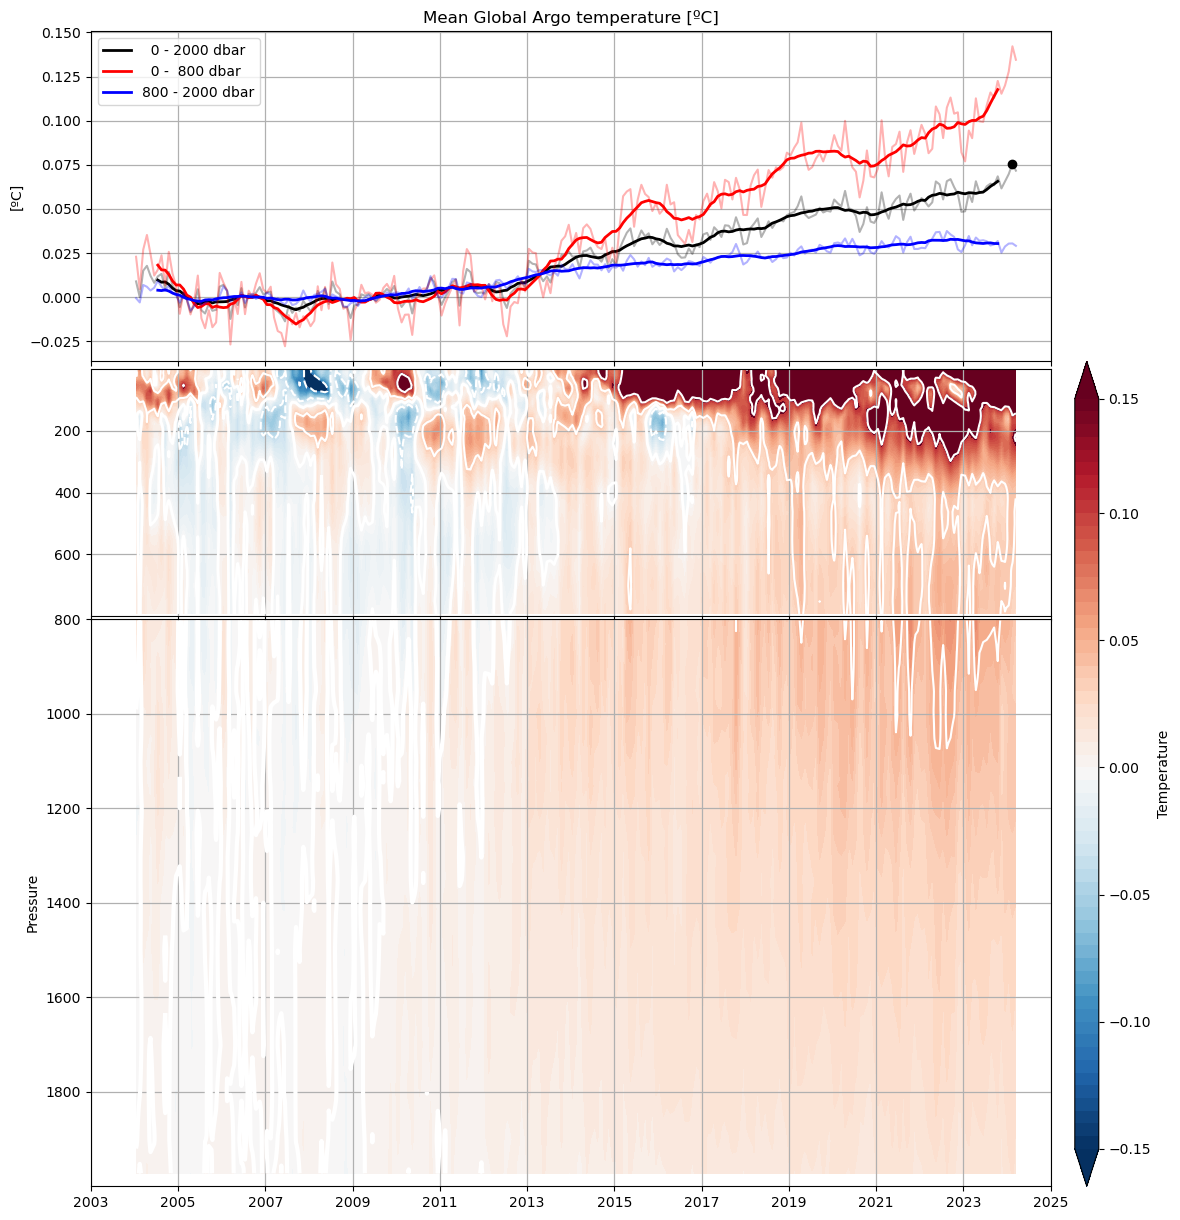

In [186]:
fig, ax = plt.subplots(3,1,figsize = (12,15),sharex=True)


# Mean values
ax[0].plot(DC_temp_anom_wmean.time,
           DC_temp_anom_wmean.sel(pre=slice(0,2000)).mean("pre"),color='k',alpha=0.3)
ax[0].plot(DC_temp_anom_wmean.time[-2],
           DC_temp_anom_wmean.sel(pre=slice(0,2000)).mean("pre")[-2],'ko')
ax[0].plot(DC_temp_anom_wmean_rolling.time,
           DC_temp_anom_wmean_rolling.sel(pre=slice(0,2000)).mean("pre"),linewidth=2,color='k',  label= '  0 - 2000 dbar')


ax[0].plot(DC_temp_anom_wmean.time,
           DC_temp_anom_wmean.sel(pre=slice(0,800)).mean("pre"),color='r',alpha=0.3)
ax[0].plot(DC_temp_anom_wmean_rolling.time,
           DC_temp_anom_wmean_rolling.sel(pre=slice(0,800)).mean("pre"),linewidth=2,color='r' ,  label= '  0 -  800 dbar')

ax[0].plot(DC_temp_anom_wmean.time,
           DC_temp_anom_wmean.sel(pre=slice(800,2000)).mean("pre"),color='b',alpha=0.3)
ax[0].plot(DC_temp_anom_wmean_rolling.time,
           DC_temp_anom_wmean_rolling.sel(pre=slice(800,2000)).mean("pre"),linewidth=2,color='b',label= '800 - 2000 dbar')
ax[0].grid(linestyle='-', linewidth=.9)
ax[0].set_position(Posiciones[0])
ax[0].legend()
ax[0].set_ylabel('[ºC]')
ax[0].set_title('Mean Global Argo temperature [ºC]')

# UpperOcean
ax[1].contour(DC_temp_anom_wmean.time, DC_temp_anom_wmean.sel(pre=slice(0,800)).pre, 
              DC_temp_anom_wmean.sel(pre=slice(0,800)).transpose()
              ,colors='w',levels=[-0.15, -0.05, 0.05, 0.15] )
ax[1].contour(DC_temp_anom_wmean.time, DC_temp_anom_wmean.sel(pre=slice(0,800)).pre, 
              DC_temp_anom_wmean.sel(pre=slice(0,800)).transpose(),colors='w', linewidths=2,
              levels=[0] )

ax[1].contourf(DC_temp_anom_wmean.time, DC_temp_anom_wmean.sel(pre=slice(0,800)).pre, 
              DC_temp_anom_wmean.sel(pre=slice(0,800)).transpose(),
              cmap='RdBu_r',levels=np.arange(-0.15,0.15,0.005),extend='both',vmin=-0.2, vmax=0.2)
ax[1].set_ylim(0,800)
ax[1].invert_yaxis()
ax[1].set_yticks([200,400,600])
ax[1].grid(linestyle='-', linewidth=.9)
ax[1].set_position(Posiciones[1])

ax[2].contour(DC_temp_anom_wmean.time, DC_temp_anom_wmean.sel(pre=slice(800,2000)).pre, 
              DC_temp_anom_wmean.sel(pre=slice(800,2000)).transpose(),colors='w',
              levels=[-0.05,0.05] )
ax[2].contour(DC_temp_anom_wmean.time, DC_temp_anom_wmean.sel(pre=slice(800,2000)).pre, 
              DC_temp_anom_wmean.sel(pre=slice(800,2000)).transpose(),colors='w', linewidths=3,
              levels=[0] )
cntr2 = ax[2].contourf(DC_temp_anom_wmean.time, DC_temp_anom_wmean.sel(pre=slice(800,2000)).pre, 
                      DC_temp_anom_wmean.sel(pre=slice(800,2000)).transpose(),
                      cmap='RdBu_r',levels=np.arange(-0.15,0.15,0.005),extend='both')
ax[2].set_ylim(800,2000)
ax[2].invert_yaxis()
ax[2].set_yticks([800,1000,1200,1400,1600,1800])
ax[2].grid(linestyle='-', linewidth=.9)
ax[2].set_position(Posiciones[2])
ax[2].set_ylabel('Pressure')

# Adding the colorbar
cbaxes = fig.add_axes([0.92, 0.1, 0.02, 0.55])  
cb = fig.colorbar(cntr2, cax=cbaxes);
cbaxes.set_yticks([-0.15, -0.10, -0.05, 0, 0.05, 0.10, 0.15])
cbaxes.set_ylabel('Temperature')

# xtick Labels
ax[0].set_xticks(pd.date_range(start="2003-01-01", end="2025-01-01",freq='2YS-JAN'));
ax[1].set_xticks(pd.date_range(start="2003-01-01", end="2025-01-01",freq='2YS-JAN'));
ax[2].set_xticks(pd.date_range(start="2003-01-01", end="2025-01-01",freq='2YS-JAN'));

ax[2].set_xticklabels(pd.date_range(start="2003-01-01", end="2025-01-01",freq='2YS-JAN').strftime('%Y'));

### Salinity

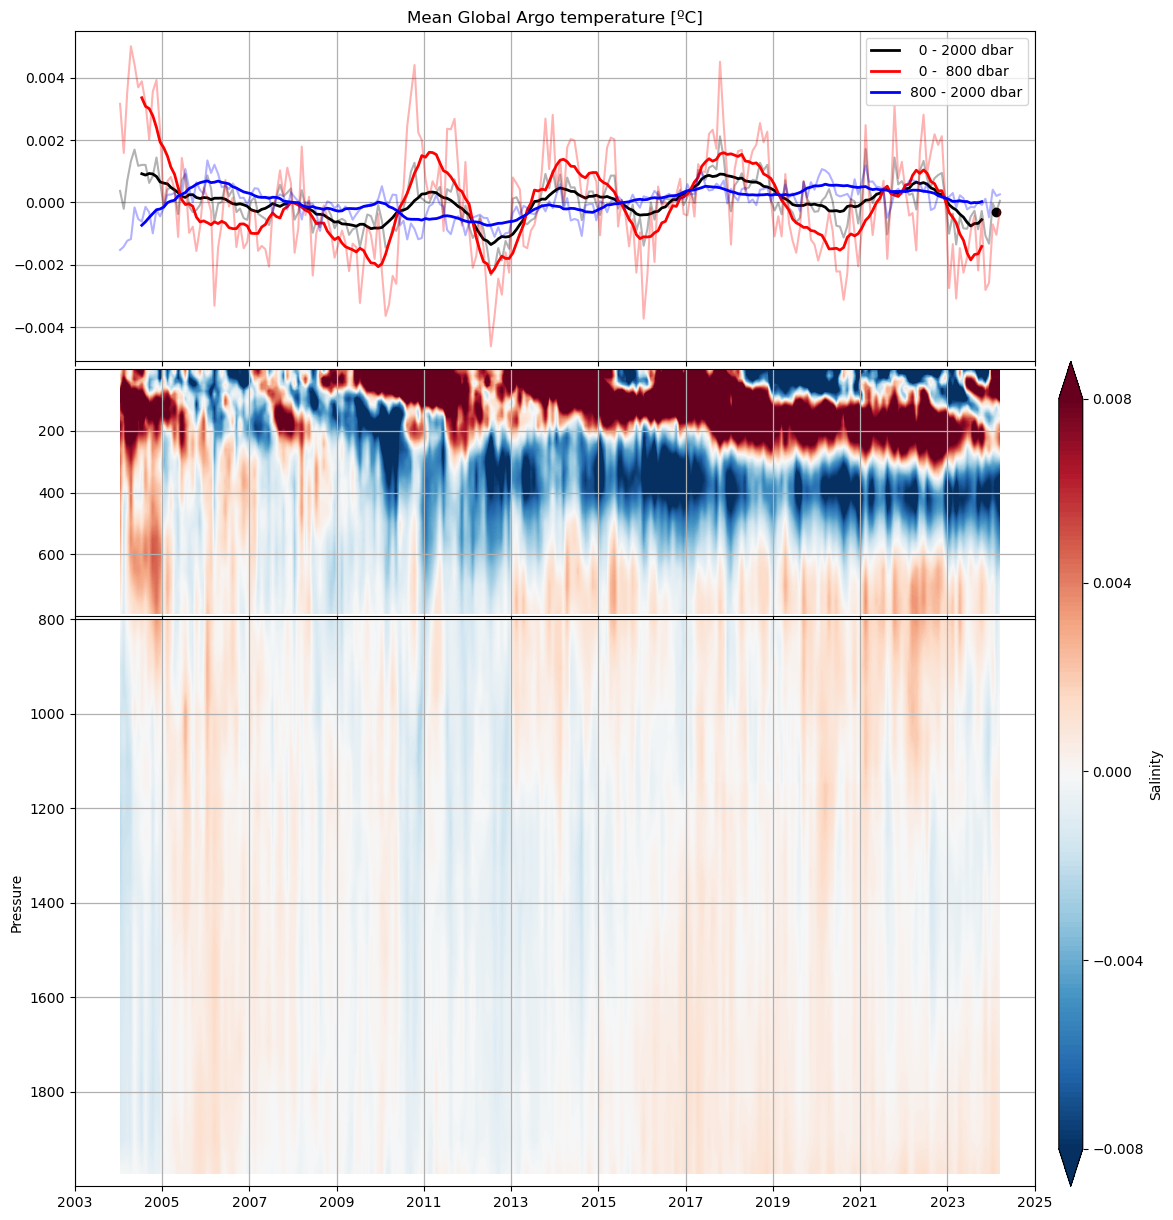

In [187]:
fig, ax = plt.subplots(3,1,figsize = (12,15),sharex=True)

# Mean values
ax[0].plot(DC_salt_anom_wmean.time,
           DC_salt_anom_wmean.sel(pre=slice(0,2000)).mean("pre"),color='k',alpha=0.3)
ax[0].plot(DC_salt_anom_wmean.time[-2],
           DC_salt_anom_wmean.sel(pre=slice(0,2000)).mean("pre")[-2],'ko')
ax[0].plot(DC_salt_anom_wmean_rolling.time,
           DC_salt_anom_wmean_rolling.sel(pre=slice(0,2000)).mean("pre"),linewidth=2,color='k',  label= '  0 - 2000 dbar')


ax[0].plot(DC_salt_anom_wmean.time,
           DC_salt_anom_wmean.sel(pre=slice(0,800)).mean("pre"),color='r',alpha=0.3)
ax[0].plot(DC_salt_anom_wmean_rolling.time,
           DC_salt_anom_wmean_rolling.sel(pre=slice(0,800)).mean("pre"),linewidth=2,color='r' ,  label= '  0 -  800 dbar')

ax[0].plot(DC_salt_anom_wmean.time,
           DC_salt_anom_wmean.sel(pre=slice(800,2000)).mean("pre"),color='b',alpha=0.3)
ax[0].plot(DC_salt_anom_wmean_rolling.time,
           DC_salt_anom_wmean_rolling.sel(pre=slice(800,2000)).mean("pre"),linewidth=2,color='b',label= '800 - 2000 dbar')

ax[0].grid(linestyle='-', linewidth=.9)
ax[0].set_position(Posiciones[0])
ax[0].legend()
ax[2].set_ylabel('[ºC]')
ax[0].set_title('Mean Global Argo salinity anomaly [ºC]')

ax[1].contourf(DC_salt_anom_wmean.time, DC_salt_anom_wmean.sel(pre=slice(0,800)).pre, 
                      DC_salt_anom_wmean.sel(pre=slice(0,800)).transpose(),20,cmap='RdBu_r',levels=np.arange(-0.008,.008,0.0001),extend='both')
ax[1].invert_yaxis()
ax[1].grid(linestyle='-', linewidth=.9)
ax[1].set_ylim(0,800)
ax[1].invert_yaxis()
ax[1].set_yticks([200,400,600])
ax[1].grid(linestyle='-', linewidth=.9)
ax[1].set_position(Posiciones[1])

cntr2 = ax[2].contourf(DC_salt_anom_wmean.time, DC_salt_anom_wmean.sel(pre=slice(800,2000)).pre, 
                      DC_salt_anom_wmean.sel(pre=slice(800,2000)).transpose(),20,cmap='RdBu_r',levels=np.arange(-0.008,.008,0.0001),extend='both')
ax[2].invert_yaxis()
ax[2].grid(linestyle='-', linewidth=.9)
ax[2].set_position(Posiciones[2])
ax[2].set_ylim(800,2000)
ax[2].invert_yaxis()
ax[2].set_yticks([800,1000,1200,1400,1600,1800])
ax[2].grid(linestyle='-', linewidth=.9)
ax[2].set_position(Posiciones[2])
ax[2].set_ylabel('Pressure')

# Adding the colorbar
cbaxes = fig.add_axes([0.92, 0.1, 0.02, 0.55])  
cb = fig.colorbar(cntr2, cax=cbaxes);
cbaxes.set_yticks([-0.008, -0.004,  0, 0.004, .008])
cbaxes.set_ylabel('Salinity')

# xtick Labels
ax[0].set_xticks(pd.date_range(start="2003-01-01", end="2025-01-01",freq='2YS-JAN'));
ax[1].set_xticks(pd.date_range(start="2003-01-01", end="2025-01-01",freq='2YS-JAN'));
ax[2].set_xticks(pd.date_range(start="2003-01-01", end="2025-01-01",freq='2YS-JAN'));

ax[2].set_xticklabels(pd.date_range(start="2003-01-01", end="2025-01-01",freq='2YS-JAN').strftime('%Y'));


Text(0.5, 1.0, 'Mean Global Argo temperature [ºC]')

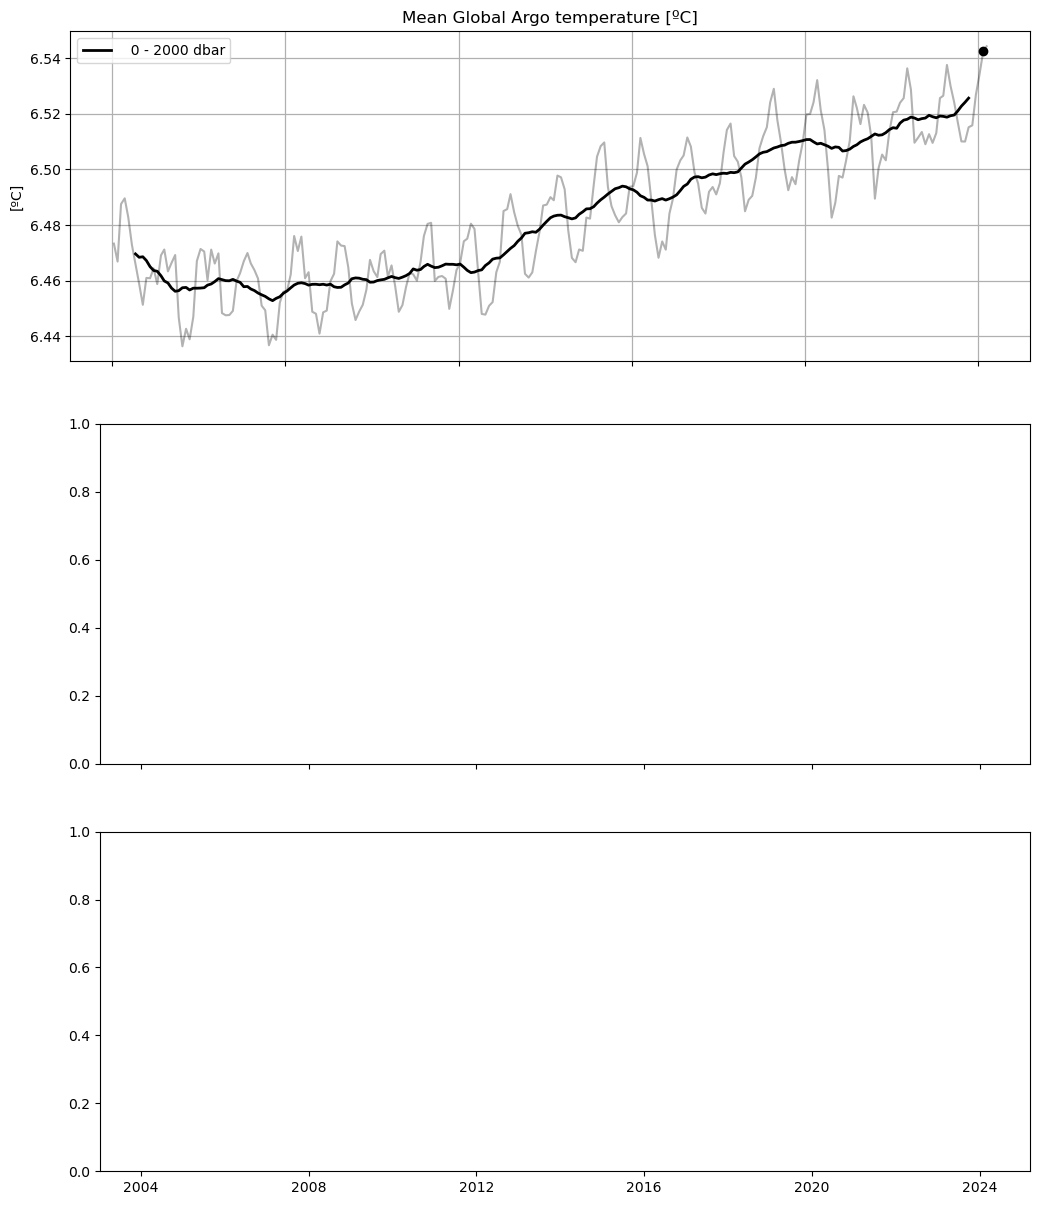

In [189]:
fig, ax = plt.subplots(3,1,figsize = (12,15),sharex=True)


# Mean values
ax[0].plot(DC_temp_wmean.time,
           DC_temp_wmean.sel(pre=slice(0,2000)).mean("pre"),color='k',alpha=0.3)
ax[0].plot(DC_temp_wmean.time[-2],
           DC_temp_wmean.sel(pre=slice(0,2000)).mean("pre")[-2],'ko')
ax[0].plot(DC_temp_wmean_rolling.time,
           DC_temp_wmean_rolling.sel(pre=slice(0,2000)).mean("pre"),linewidth=2,color='k',  label= '  0 - 2000 dbar')

ax[0].grid(linestyle='-', linewidth=.9)
ax[0].set_position(Posiciones[0])
ax[0].legend()
ax[0].set_ylabel('[ºC]')
ax[0].set_title('Mean Global Argo temperature [ºC]')
